In [18]:
import torch.utils.data
import scipy.io as sio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:

class TrainData(torch.utils.data.Dataset):
    def __init__(self, img, target, transform=None, target_transform=None):
        self.img = img.float()
        self.target = target.float()
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, target = self.img[index], self.target[index]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.img)


class Data:
    def __init__(self, dataset, device):
        super(Data, self).__init__()

        data_path = "./data/" + dataset + "_dataset.mat"
        if dataset == 'samson':
            self.P, self.L, self.col = 3, 156, 95
        elif dataset == 'jasper':
            self.P, self.L, self.col = 4, 198, 100
        elif dataset == 'urban':
            self.P, self.L, self.col = 4, 162, 306
        elif dataset == 'apex':
            self.P, self.L, self.col = 4, 258, 110
        elif dataset == 'dc':
            self.P, self.L, self.col = 6, 191, 290

        data = sio.loadmat(data_path)
        self.Y = torch.from_numpy(data['Y'].T).to(device)
        self.A = torch.from_numpy(data['A'].T).to(device)
        self.M = torch.from_numpy(data['M'])
        self.M1 = torch.from_numpy(data['M1'])

    def get(self, typ):
        if typ == "hs_img":
            return self.Y.float()
        elif typ == "abd_map":
            return self.A.float()
        elif typ == "end_mem":
            return self.M
        elif typ == "init_weight":
            return self.M1

    def get_loader(self, batch_size=1):
        train_dataset = TrainData(img=self.Y, target=self.A, transform=transforms.Compose([]))
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=False)
        return train_loader



In [4]:
data = Data('samson', 'cpu')

In [11]:
data.M1.shape

torch.Size([156, 3])

In [12]:
data.P

3

In [22]:
hs = data.get("hs_img")
hs.shape

torch.Size([9025, 156])

In [15]:
9025 / 95

95.0

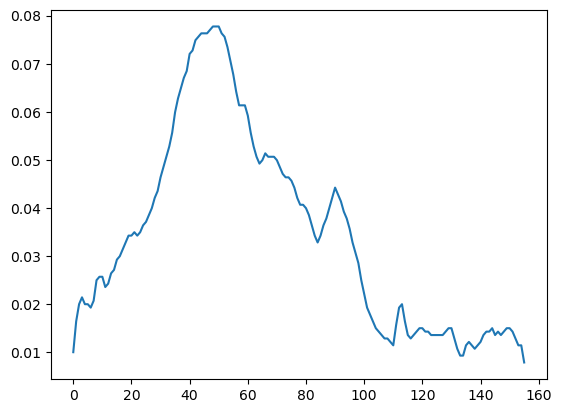

In [20]:
plt.plot(hs[100])

In [21]:
import numpy as np

In [24]:
hs_im = hs.reshape((95,95,-1))

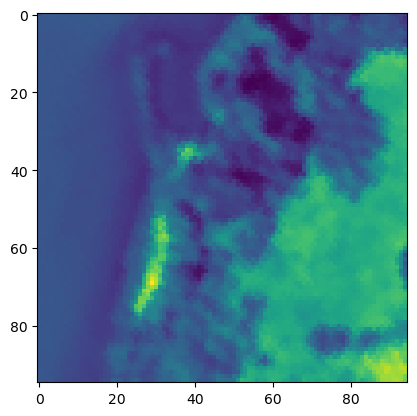

In [26]:
plt.imshow(hs_im[:,:,45])

In [27]:
import vegesense.functions

In [35]:

data = hs_im.reshape(-1, hs_im.shape[2])

In [36]:
data.shape

torch.Size([9025, 156])

In [33]:
hs_im.shape

torch.Size([95, 95, 156])

In [34]:
hs.shape

torch.Size([9025, 156])

In [ ]:
def VCA_torch(cube, n_endmembers, wavelength_band=0, flattened=False, epsilon=0):
    p = int(n_endmembers)
    data = cube.res
    data = cube.stack({'xy': ('y', 'x')}).transpose('band', 'xy')
    data = np.nan_to_num(data).clip(-10 ** 10, 10 ** 10)
    pixels = data.shape[1]
    bands = data.shape[0]
    CovMat = np.divide(np.matmul(data, data.T), pixels)
    [U, S, VT] = la.svds(CovMat, k=p)
    X = np.matmul(np.transpose(U), data)
    X_mean = np.mean(X, axis=1)
    if epsilon > 0:
        Y = np.divide(X, np.matmul(np.transpose(X), X_mean) + epsilon)
    else:
        Y = np.nan_to_num(np.divide(X, np.matmul(np.transpose(X), X_mean))).clip(-10 ** 10, 10 ** 10)
    eu = np.zeros((1, p))
    eu[0, p - 1] = 1

    A = np.zeros((p, p))
    A[:, 0] = eu

    I = np.eye(p)
    idx = np.zeros((p, 1))
    em = np.zeros((bands, p))
    for ik in range(p):
        w = np.random.rand(p, 1)
        tmp = np.matmul(I - np.matmul(A, np.linalg.pinv(A)), w)
        f = tmp / np.linalg.norm(tmp)
        v = np.matmul(np.transpose(f), Y)
        k = np.argmax(np.abs(v))
        A[:, ik] = Y[:, k]
        idx[ik] = k
        em[:, ik] = np.matmul(U, X[:, k])


    ab_maps = __fva(data, em, p, cube)
    return ab_maps, em 


In [41]:
aa = torch.tensor([0,1,2,3,4,5])
bb = 1

In [43]:
torch.concatenate([aa[aa != bb], aa[aa == bb]]) 

tensor([0, 2, 3, 4, 5, 1])

In [99]:
def __selected_idx_last(idxs, sel_idx):
    return torch.concatenate([idxs[idxs != sel_idx], idxs[idxs == sel_idx]])
def __selected_idx_first(idxs, sel_idx):
    return torch.concatenate([idxs[idxs == sel_idx], idxs[idxs != sel_idx]])
def __shape_without_band(shape, idxs, sel_idx):
    return idxs[idxs != sel_idx]

In [73]:
import scipy.sparse.linalg as la


In [77]:
U

array([[-0.00883563, -0.0310911 , -0.00685165],
       [-0.02054482, -0.03453445, -0.00816881],
       [-0.02633113, -0.03666722, -0.00902773],
       [-0.02812845, -0.03820103, -0.00962985],
       [-0.0254105 , -0.03858605, -0.00979232],
       [-0.02659355, -0.03995327, -0.01037497],
       [-0.02560558, -0.04077237, -0.01073012],
       [-0.02558252, -0.04161273, -0.0111467 ],
       [-0.03636009, -0.04528132, -0.01276103],
       [-0.03734793, -0.04683557, -0.01344098],
       [-0.03623246, -0.04787676, -0.01387932],
       [-0.02728642, -0.04685426, -0.01341651],
       [-0.0280342 , -0.04773236, -0.01376244],
       [-0.0341463 , -0.05019574, -0.01469523],
       [-0.03489555, -0.0510099 , -0.01492168],
       [-0.03808925, -0.05238137, -0.0153854 ],
       [-0.03864237, -0.05305253, -0.0155557 ],
       [-0.04159493, -0.05472148, -0.01610808],
       [-0.0442418 , -0.05660272, -0.01671378],
       [-0.04638803, -0.05833102, -0.01725664],
       [-0.04620682, -0.05930565, -0.017

In [111]:
n_endmembers = 3
cube = hs_im
wavelength_band=2
flattened=False
epsilon=0
p = int(n_endmembers)
def VCA_torch(cube, n_endmembers, wl_band, epsilon=0):
    bands = __selected_idx_first(torch.arange(0, len(cube.shape)), wavelength_band)
    cube = cube.permute(*bands)
    shape_without_band = cube.shape[1:]
    data = cube.reshape(cube.shape[0], -1)

    pixels = data.shape[1]
    bands = data.shape[0]
    CovMat = torch.divide(torch.matmul(data, data.T), pixels)
    [U, S, VT] = la.svds(CovMat.numpy(), k=p)
    U = torch.tensor(U.copy())
    S = torch.tensor(S.copy())
    VT = torch.tensor(VT.copy())
    X = torch.matmul(U.T, data)
    X_mean = torch.mean(X, axis=1)
    if epsilon > 0:
        Y = torch.divide(X, torch.matmul(X.T, X_mean) + epsilon)
    else:
        Y = torch.nan_to_num(
            torch.divide(X, torch.matmul(X.T, X_mean))).clip(-10 ** 10, 10 ** 10)
    eu = torch.zeros((1, p))
    eu[0, p - 1] = 1

    A = torch.zeros((p, p))
    A[:, 0] = eu

    I = torch.eye(p)
    idx = torch.zeros((p, 1))
    em = torch.zeros((bands, p))
    for ik in range(p):
        w = torch.rand(p, 1)
        tmp = torch.matmul(I - torch.matmul(A, torch.linalg.pinv(A)), w)
        f = tmp / torch.linalg.norm(tmp)
        v = torch.matmul(f.T, Y)
        k = torch.argmax(torch.abs(v))
        A[:, ik] = Y[:, k]
        idx[ik] = k
        em[:, ik] = torch.matmul(U, X[:, k])


    ab_maps = __fva_torch(data, em, p, shape_without_band)
    return ab_maps, em 


In [110]:
def __fva_torch(data, em, p, shape):
    '''
    Filter vector algorithm
    Jeffrey H. Bowles, Peter J. Palmadesso, John A. Antoniades,
    Mark M. Baumback, Lee J. Rickard,
    "Use of filter vectors in hyperspectral data analysis,"
    Proc. SPIE 2553, Infrared Spaceborne Remote Sensing III,
    (29 September 1995);
    '''
    # print('done')
    p_1 = data.shape[0]
    p_2 = em.shape[0]

    # print('done')
    P = torch.matmul(
        torch.linalg.pinv(torch.matmul(em.T, em)),
        em.T
    )

    # print('done')
    # print(P.shape)
    # print(data.shape)
    ab_maps = torch.matmul(P, data)

    ab_maps = ab_maps.reshape(*shape, p) ## FIks tis

    # print('done')
    return ab_maps


In [112]:
ab, em = VCA_torch(hs_im, 3, 2)

In [113]:
em.shape

torch.Size([156, 3])

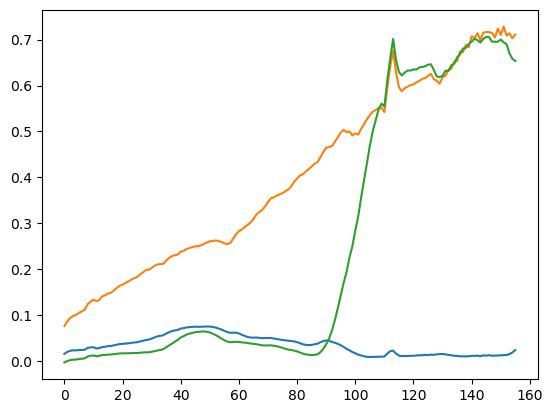

In [114]:
for i in em.T:
    plt.plot(i)

In [65]:
cube.transpose(1,2,0)

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [121]:
import xarray as xr
import os
path = '/home/leeviann/proj/hyperspectral_data/Grand_Lettuce_Experiment/'
array = xr.load_dataset(
    os.path.join(path, 'selected_reflectances/1134.nc')
).reflectance

In [122]:
array

<xarray.DataArray 'reflectance' (band: 204, y: 512, x: 512)>
array([[[0.12240611, 0.14280713, 0.14280713, ..., 0.18360917,
         0.16320815, 0.14280713],
        [0.16320815, 0.16320815, 0.14280713, ..., 0.18360917,
         0.18360917, 0.18360917],
        [0.14280713, 0.14280713, 0.16320815, ..., 0.16320815,
         0.18360917, 0.18360917],
        ...,
        [0.16320815, 0.16320815, 0.14280713, ..., 0.16320815,
         0.18360917, 0.18360917],
        [0.16320815, 0.16320815, 0.16320815, ..., 0.18360917,
         0.18360917, 0.18360917],
        [0.16320815, 0.14280713, 0.16320815, ..., 0.18360917,
         0.18360917, 0.18360917]],

       [[0.13310853, 0.13310853, 0.13310853, ..., 0.14974709,
         0.13310853, 0.14974709],
        [0.11646996, 0.13310853, 0.11646996, ..., 0.16638566,
         0.16638566, 0.16638566],
        [0.13310853, 0.13310853, 0.13310853, ..., 0.16638566,
         0.14974709, 0.16638566],
...
        [0.53674053, 0.53674053, 0.54769442, ..., 0.53674053,
         0.54769442, 0.54769442],
        [0.50387887, 0.53674053, 0.53674053, ..., 0.53674053,
         0.53674053, 0.53674053],
        [0.53674053, 0.53674053, 0.55864831, ..., 0.54769442,
         0.54769442, 0.53674053]],

       [[0.53976022, 0.525556  , 0.51135178, ..., 0.59657708,
         0.6107813 , 0.58237286],
        [0.49714757, 0.53976022, 0.53976022, ..., 0.6107813 ,
         0.59657708, 0.58237286],
        [0.525556  , 0.525556  , 0.525556  , ..., 0.6107813 ,
         0.59657708, 0.58237286],
        ...,
        [0.49714757, 0.46873913, 0.49714757, ..., 0.49714757,
         0.48294335, 0.46873913],
        [0.48294335, 0.48294335, 0.48294335, ..., 0.48294335,
         0.46873913, 0.48294335],
        [0.45453492, 0.46873913, 0.48294335, ..., 0.48294335,
         0.48294335, 0.48294335]]])
Coordinates:
    wavelength  (band) float64 397.3 400.2 403.1 406.0 ... 997.4 1e+03 1.004e+03
  * band        (band) int64 1 2 3 4 5 6 7 8 ... 197 198 199 200 201 202 203 204
  * x           (x) float64 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * y           (y) float64 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes: (12/225)
    Band_1:            397.32
    Band_10:           423.29
    Band_100:          687.65
    Band_101:          690.64
    Band_102:          693.62
    Band_103:          696.61
    ...                ...
    lines:             512
    longitude:         0.00000000
    samples:           512
    sensor_type:       SPECIM IQ
    tint:              51
    grid_mapping:      spatial_ref

In [129]:
array.dims != 'band'

True

In [131]:
array.shape[np.array(array.dims) != 'band']

TypeError: only integer scalar arrays can be converted to a scalar index

In [136]:
np.array(array.shape)[np.array(array.dims) != 'band']

array([512, 512])

In [138]:
dims = np.array(array.dims)[np.array(array.dims) != 'band']

In [145]:
#dims = ('y', 'x')

In [147]:
dims = tuple(dims)

In [148]:
dims

('y', 'x')

In [149]:
array.stack({'xy':dims})

<xarray.DataArray 'reflectance' (band: 204, xy: 262144)>
array([[0.12240611, 0.14280713, 0.14280713, ..., 0.18360917, 0.18360917,
        0.18360917],
       [0.13310853, 0.13310853, 0.13310853, ..., 0.16638566, 0.16638566,
        0.16638566],
       [0.10784555, 0.10784555, 0.09436486, ..., 0.14828764, 0.13480694,
        0.13480694],
       ...,
       [0.61873074, 0.60841856, 0.62904292, ..., 0.55685767, 0.53623331,
        0.53623331],
       [0.59150997, 0.61341775, 0.62437164, ..., 0.54769442, 0.54769442,
        0.53674053],
       [0.53976022, 0.525556  , 0.51135178, ..., 0.48294335, 0.48294335,
        0.48294335]])
Coordinates:
    wavelength  (band) float64 397.3 400.2 403.1 406.0 ... 997.4 1e+03 1.004e+03
  * band        (band) int64 1 2 3 4 5 6 7 8 ... 197 198 199 200 201 202 203 204
  * xy          (xy) object MultiIndex
  * y           (xy) float64 0.5 0.5 0.5 0.5 0.5 ... 511.5 511.5 511.5 511.5
  * x           (xy) float64 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes: (12/225)
    Band_1:            397.32
    Band_10:           423.29
    Band_100:          687.65
    Band_101:          690.64
    Band_102:          693.62
    Band_103:          696.61
    ...                ...
    lines:             512
    longitude:         0.00000000
    samples:           512
    sensor_type:       SPECIM IQ
    tint:              51
    grid_mapping:      spatial_ref